##### The objective of this notebook is to explore our dataset to curate an appropriate dataset for our training.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

/Users/admin/Library/Mobile Documents/com~apple~CloudDocs/Documents/TECHBABE/PYTHON_PROJECTS/pricer_agentic_ai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# environment

load_dotenv(override=True)
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
from price_intel.data.loaders import ItemLoader

In [4]:
%matplotlib inline

In [5]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [6]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


100%|██████████| 2004/2004 [30:43<00:00,  1.09it/s]


Completed Automotive with 911,688 datapoints in 31.2 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [20:22<00:00,  1.32it/s]


Completed Electronics with 443,473 datapoints in 20.6 mins
Loading dataset Office_Products


100%|██████████| 711/711 [04:30<00:00,  2.63it/s]


Completed Office_Products with 240,394 datapoints in 4.8 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [15:52<00:00,  1.55it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 16.1 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████| 1289/1289 [13:17<00:00,  1.62it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 20.8 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [06:31<00:00,  2.28it/s]


Completed Toys_and_Games with 340,479 datapoints in 12.7 mins
Loading dataset Appliances


Generating full split: 94327 examples [00:10, 9123.60 examples/s] 
100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


Completed Appliances with 28,625 datapoints in 1.0 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [00:32<00:00,  6.65it/s]


Completed Musical_Instruments with 66,829 datapoints in 2.0 mins


In [7]:
print(f"A total of {len(items):,} items")

A total of 2,811,408 items


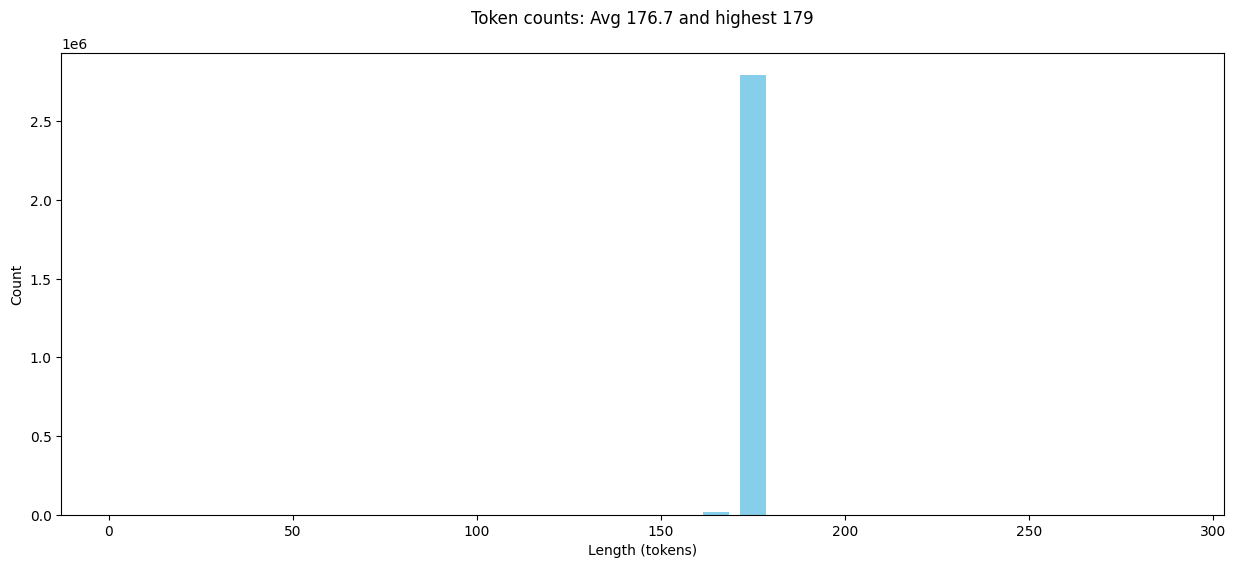

In [18]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

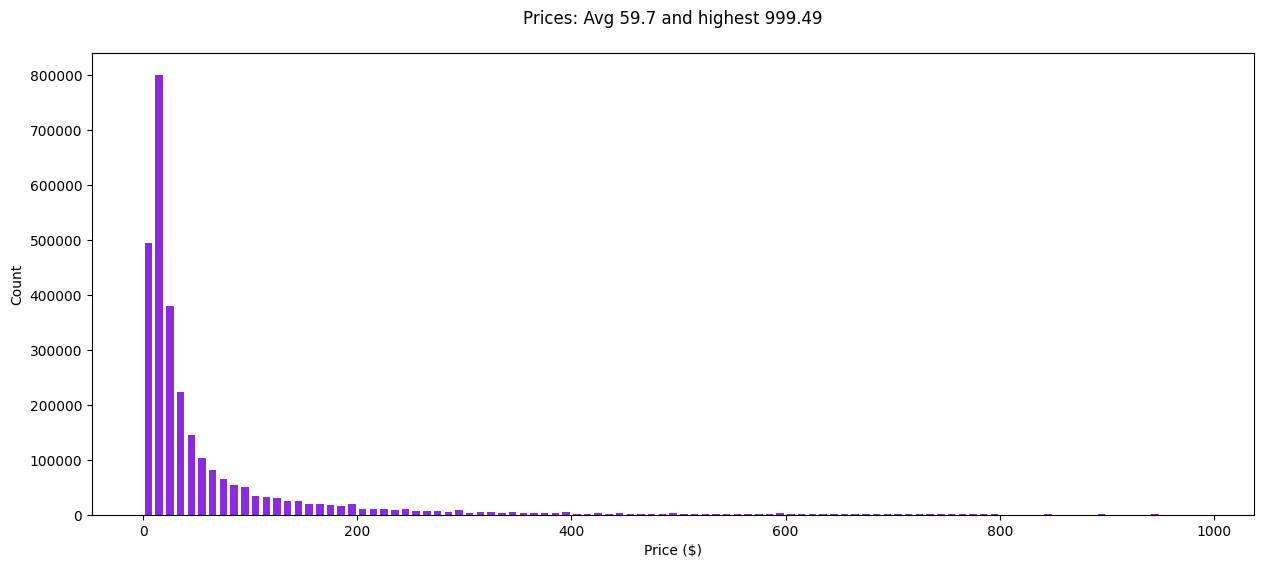

In [19]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

Prices are between 1 and 999, because that's the constraint we've put in to make sure that we avoid huge outliers that will distort our training. However, the dataset is very skewed to the smaller numbers, and there's a very thin tail. We do have data points in there which reach up to 909.49, but you can barely see them. They barely touch the axis because the dataset is so dominated by the 800,000 or so that are coming in at lower cost points.

Let's have a quick look at the categories:

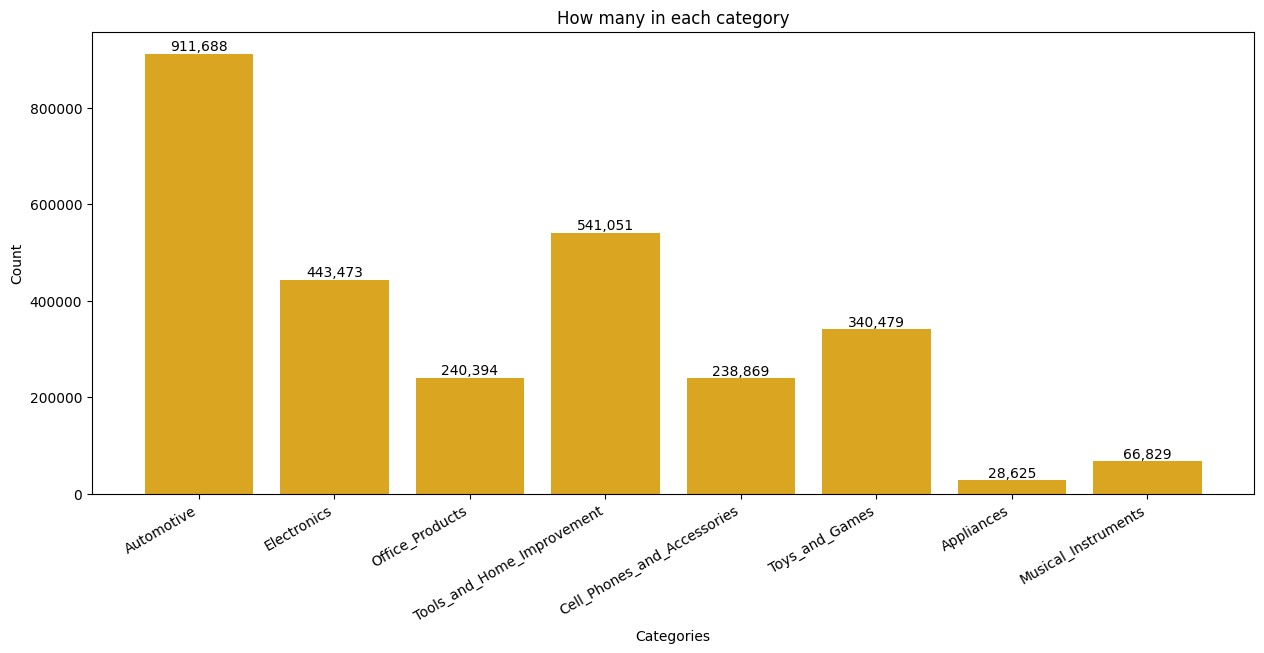

In [20]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

Automotive is dominating here with 900,000, followed by tools and home improvement with 541,000, followed by electronics with 400,000.

We need to craft a dataset which is more balanced in terms of prices and categories.


In [23]:
from collections import defaultdict


In [24]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [25]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


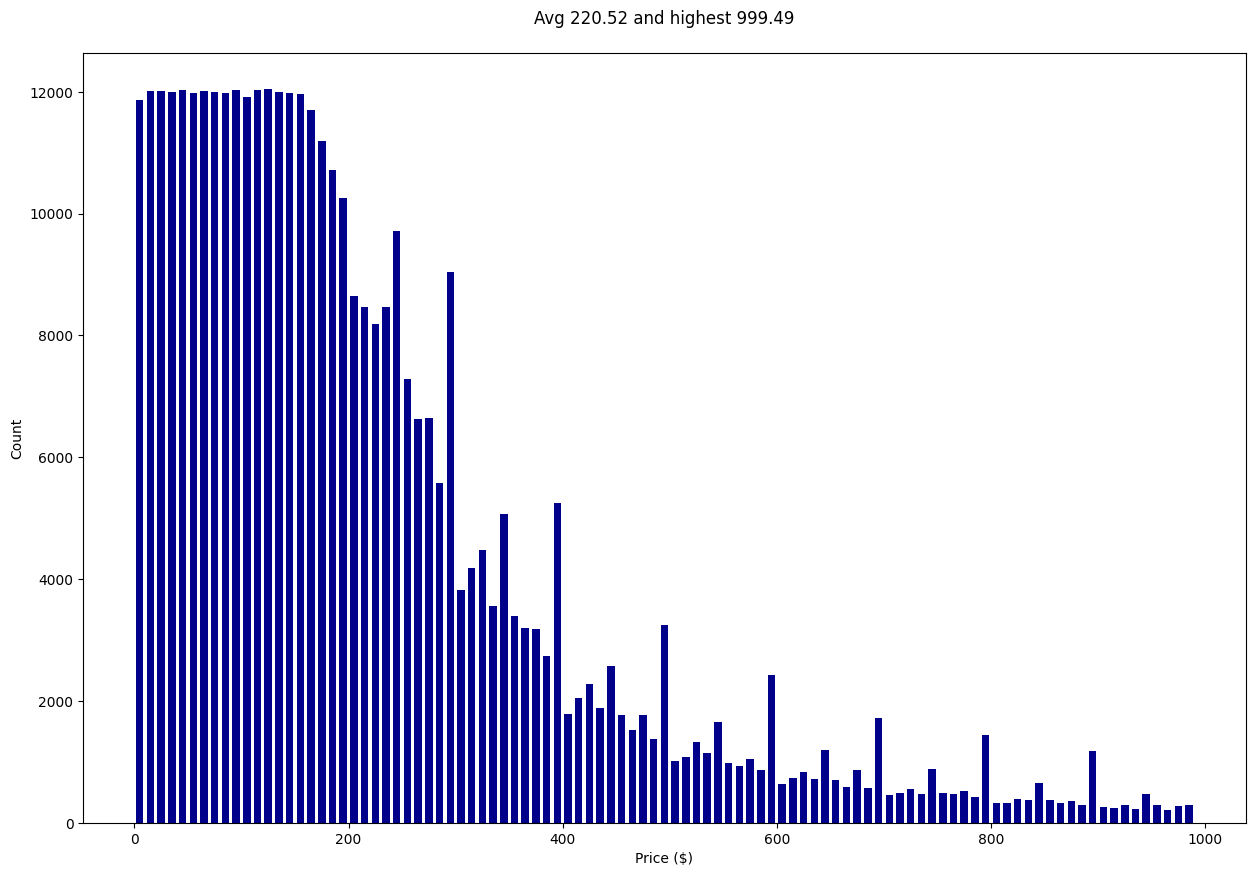

In [26]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

OK, the average price definetly raised so that's good. There also is a smoother population of prices.

Let's see the categories:

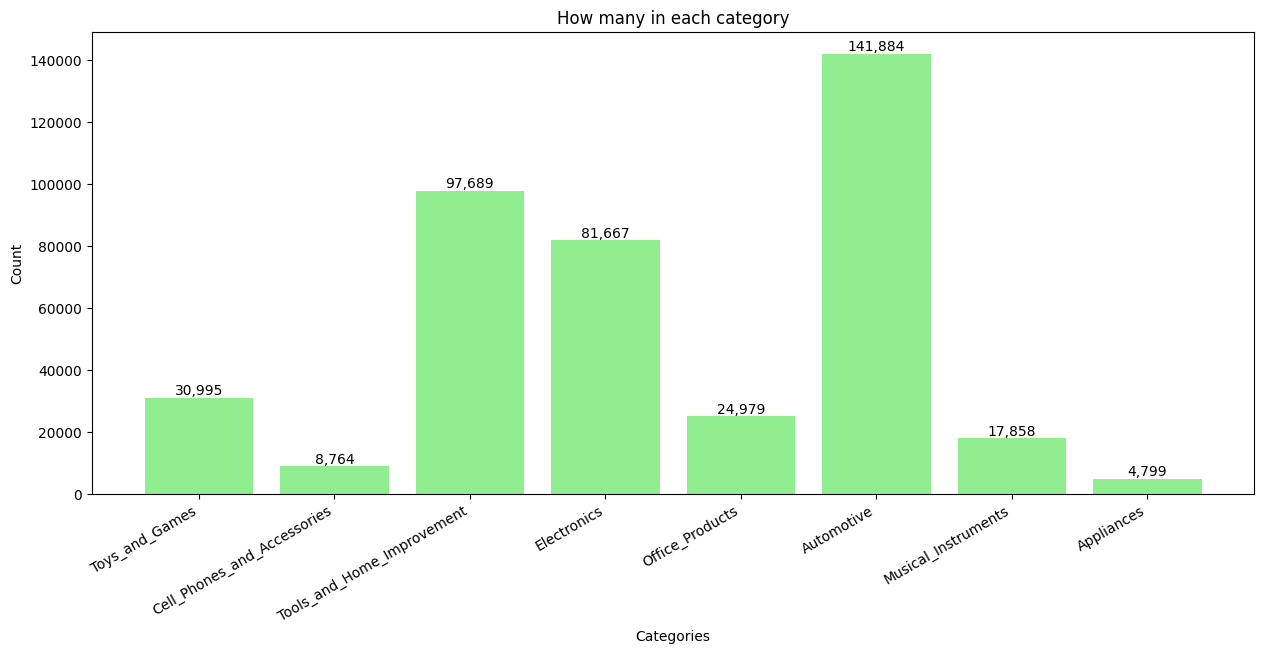

In [27]:

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()


Automotive still in the lead, but improved somewhat.

Our dataset is curated, and it is solid. We can now refactor our logic to proper Python modules.